# Transcriptions Preparation

This notebook outlines the steps taken prior to obtaining human transcriptions during the radio ASR benchmarking task. 

To prepare for the transcriptions, the following steps were taken:
1. Obtain 100 random radio clips from each of 7 countries from Jan-Oct 2021, then run these clips through DeepSpeech ASR.
2. Determine which clips, from the DeepSpeech transcriptions, are about COVID-19.
3. Randomly sample covid-related clips (sample 5 from each country) and move to a separate folder. Note that these are the _raw audio files_ (the files having been chosen using DeepSpeech proxy). These are put into `big_volume/covid_clips_before_segmenting`
4. Segment each of these clips into shorter clips using pydub and Silero VAD. Note that we are splitting the _raw audio files_. These are put into `big_volume/covid_clips_after_segmenting`

### Tools for segmentation
* Using [`pydub`](https://github.com/jiaaro/pydub) to load in the WAV files and to export them
* Using [`Silero VAD`](https://github.com/snakers4/silero-vad#adaptive-way) to split the audio segments


## 1. Obtain 100 random radio clips + DeepSpeech Transcriptions

Tomaz has obtained 100 random audio clips from each of the seven countries (Ghana, Kenya, Mauritius, Namibia, Nigeria, Rwanda, South Africa) during the time period of January to October 2021. These audio clips are run through the DeepSpeech ASR. 

The motivation for this is that this is a quick and easy proxy (since DeepSpeech model is cheaper than Amazon Transcribe model) to find the clips that are talking about the COVID-19 pandemic. (This part was performed before we learned about the NVIDIA Riva model, so this step could similarly have been done using NVIDIA).

In [59]:
ls /efs-who/100-random-clips-transcriptions/100-random-clips/

ghana/  kenya/  mauritius/  namibia/  nigeria/  rwanda/  south_africa/  take-2/


In [60]:
ls /efs-who/100-random-clips-transcriptions/100-random-clips/take-2

kenya/


In [61]:
# Directory where Isaiah put the deepspeech transcriptions for the clips Tomaz sampled for me
CLIPS_DIR = '/efs-who/100-random-clips-transcriptions/100-random-clips/'

In [62]:
transcriptions = []

for country in [c for c in os.listdir(CLIPS_DIR) if c!='take-2']:
    country_path = os.path.join(CLIPS_DIR, country)
    for city in os.listdir(country_path):
        city_path = os.path.join(country_path, city)
        for date in os.listdir(city_path):
            date_path = os.path.join(city_path, date)
            for csv in os.listdir(date_path):
                temp_df = pd.read_csv(os.path.join(date_path, csv))
                transcriptions.append({
                    "country": country,
                    "city": city,
                    "date": date,
                    "transcription": temp_df["date"].values[0],
                    "filename": temp_df["file name"].values[0]
                    
                })
#                 print(csv, date, city, country)        

In [63]:
deepspeech_df = pd.DataFrame(transcriptions)
# Drop null
deepspeech_df = deepspeech_df[~deepspeech_df.transcription.isnull()]
# Reset index
deepspeech_df.reset_index(inplace=True, drop=True)


In [64]:
len(deepspeech_df)

659

In [65]:
deepspeech_df.country.value_counts()

rwanda          100
nigeria         100
south_africa    100
namibia         100
ghana           100
mauritius        98
kenya            61
Name: country, dtype: int64

## 2. Determine which clips are about COVID

This can be done in two ways. In the publication, we use Option 2, as the Option 1 (using EARS taxonomy) was too broad and resulted in _too many_ segments that were not necessarily actually about COVID.

### Option 1: Using EARS to find covid segments

First, obtain the EARS taxonomy from the dashboard repo.

In [8]:
# ! wget https://raw.githubusercontent.com/UNGlobalPulse/UNGP-WHO-Radio-Dashboard/master/data/EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE

--2021-11-04 16:19:45--  https://raw.githubusercontent.com/UNGlobalPulse/UNGP-WHO-Radio-Dashboard/master/data/EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13501 (13K) [text/plain]
Saving to: ‘EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE.1’

EARSQueries_en.csv? 100%[===================>]  13.18K  --.-KB/s    in 0s      

2021-11-04 16:19:45 (97.5 MB/s) - ‘EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE.1’ saved [13501/13501]



In [182]:
def convert_boolean_to_regex(s):
    """Transforms a SQL-like boolean query to a regex... hope this works!"""
    # Replace OR and AND
    s = s.replace(" OR ", "|")
    # Replace quotations
    s = s.replace('"', '')
    # Drop the *
    s = s.replace('*', '')
    # replace NEAR/10
    s = s.replace(") NEAR/10 (", "|")
    # Special case with extra parens
    s = s.replace(")))) AND (", "|")
    s = s.replace("))) AND (", "|")
    s = s.replace("(", "")
    s = s.replace(")", "")

    # Lowercase
    s = s.lower()
    
    return s

def transcription_in_taxonomy(transcription):
    return any([w in transcription for w in covid_taxonomy])

In [183]:
covid_words = ["covert nineteen", "covered nineteen", "cove nineteen",
               "clover nineteen", "covet nineteen", "coffee nineteen",
               "crown of virus", "virus"]

ears_queries = pd.read_csv('EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE', header=None)
ears_queries.columns=['query_name', 'query']

In [184]:
ears_queries["regex_query"] = ears_queries["query"].apply(convert_boolean_to_regex)

# Append the taxonomy for radio covid words
ears_queries = ears_queries.append({
    "query_name": "COVID_WORDS",
    "regex_query": "|".join(covid_words)
}, ignore_index=True)

In [185]:
ears_queries

,query_name,query,regex_query
0,Cause,"""from animals"" OR ""deliberate spread"" OR ""labo...",from animals|deliberate spread|laboratory acci...
1,Stigma,stigma OR racism OR racist OR xenophobia OR xe...,stigma|racism|racist|xenophobia|xenophobic|int...
2,Immunity,"""immunity"" OR ""infected once"" OR ""develop immu...",immunity|infected once|develop immunity|grow i...
3,Confirmed Symptoms,"cough OR ""no breath"" OR ""breathless"" OR ""diffi...",cough|no breath|breathless|difficult to breath...
4,Other discussed symptoms,"""cold symptoms"" OR ""cold symptom"" OR ""Allergy ...",cold symptoms|cold symptom|allergy symptoms|al...
5,Asymptomatic,"""asymptom*""",asymptom
6,Pre-Symptomatic,"""pre-sympto*"" OR ""presympto*""",pre-sympto|presympto
7,Means of Transmission,"""transmi*"" OR ""spread"" OR ""transmitted"" OR ""dr...",transmi|spread|transmitted|droplets|propagate|...
8,Protection from Transmission,"""Personal Protective Equipment"" OR ""PPE"" OR ""g...",personal protective equipment|ppe|gloves|scrub...
9,Risk - Underlying Conditions,"""risk"" OR ""risk*"" OR ""danger"" OR ""threat"" OR ""...",risk|risk|danger|threat|threat|get|infect|wors...


In [32]:
ears_subset = ears_queries[ears_queries.query_name.isin(["Immunity", "Asymptomatic", "Means of Transmission",
                                          "Protection from Transmission", "Vaccines",
                                          "Reduction of Movement", "COVID_WORDS"])]

In [33]:
found_indices = set()

for i, q in ears_subset.iterrows():
    truth_values = deepspeech_df[deepspeech_df.transcription.apply(lambda x: bool(re.search(q["regex_query"], x)))]
    truth_value_indices = truth_values.index.values
    found_indices.update(truth_value_indices)
    print(len(found_indices))

2
2
229
300
308
316
320


In [34]:
covid_segmented_ears = deepspeech_df.iloc[list(found_indices)]

In [35]:
covid_segmented_ears.country.value_counts()

ghana           57
south_africa    56
nigeria         56
namibia         51
rwanda          39
mauritius       35
kenya           26
Name: country, dtype: int64

### Option 2: Using curated covid taxonomy to find covid segments

My process of obtaining these words:
* Starting with seed of "nineteen" and manually going through two transcriptions per country and seeing what variations of covid-19 were nearby"
* Using the EARS taxonomy and selectively choosing seed words related to symptoms, immunity, side effects, vaccines, and transmission. Randomly spot-check a few examples to make sure that the transcription for that seed word looks related to covid in some way

In [90]:
covid_taxonomy = ["covert nineteen", "covered nineteen", "cove nineteen",  # covid 19
                  "clover nineteen", "covet nineteen", "coffee nineteen",  # covid 19
                  "coronated",
                  "symptom", "inoculating", "transmission", "transmit",
                  "vaccin", "variant", "virus", "doses", "delta", # vaccine
                  "oxford", "actinic vain", "johnson and",
                  "first wave", "second wave",
                  "immun", "infect", "contracted", # immunity
                  "quarantine", "pandemic", "preventative",
                  "side effect", # side effects
                 ]

def transcription_in_taxonomy(transcription):
    return any([w in transcription for w in covid_taxonomy])

In [91]:
covid_segmented_df = deepspeech_df[deepspeech_df.transcription.apply(transcription_in_taxonomy)]

In [92]:
covid_segmented_df.country.value_counts()

south_africa    13
namibia         12
rwanda           8
nigeria          5
kenya            5
ghana            3
mauritius        1
Name: country, dtype: int64

In [93]:
deepspeech_df.country.value_counts()

ghana           100
nigeria         100
namibia         100
south_africa    100
rwanda          100
mauritius        98
kenya            61
Name: country, dtype: int64

What percentage are "covid"-related? 

Mauritius is jibberish as is Ghana

(Caveat, Kenya only has 61 and idk why)

In [95]:
percentage_covid_segments = covid_segmented_df.country.value_counts() / deepspeech_df.country.value_counts()

In [97]:
percentage_covid_segments * 100

ghana            3.000000
kenya            8.196721
mauritius        1.020408
namibia         12.000000
nigeria          5.000000
rwanda           8.000000
south_africa    13.000000
Name: country, dtype: float64

## 3. Randomly Sample COVID-related clips
Next, I randomly sample the 5-minute DeepSpeech transcriptions (5 per country) and move them to a separate folder
audio clips (i.e. 5-min transcrtiCopy and save relevant files to another folder: `big_volume/covid_clips_before_segmenting`.

In [111]:
import os
import shutil
import glob

In [25]:
# Need to get 5 for each one
subset_countries = ['south_africa', 'namibia', 'rwanda', 'nigeria', 'kenya']
samples_to_segment = covid_segmented_df[covid_segmented_df.country.isin(subset_countries)]\
    .groupby("country")\
    .sample(n=5, random_state=42)

In [90]:
samples_to_segment.iloc[14].mp3_filename.split('/')

['',
 'efs-who',
 '100-random-clips',
 'nigeria',
 'ado-ekiti',
 '2021-10-08',
 'EktiRadio_2021-10-08T16.40.0.csv']

In [91]:
# Set the mp3 filename
samples_to_segment["mp3_filename"] = samples_to_segment.filename.str.replace('100-random-clips-transcriptions/100-random-clips', 
                                             '100-random-clips')

samples_to_segment["mp3_filename"] = samples_to_segment["mp3_filename"].str.replace('.csv', '')

<ipython-input-91-d3e3e65626c5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  samples_to_segment["mp3_filename"] = samples_to_segment["mp3_filename"].str.replace('.csv', '')


In [122]:
'.'.join(filename.split('/')[-1].split('.')[:-1]) + '.wav'

'HBRRadio_2021-09-10T04.00.02.wav'

In [123]:
OUT_FOLDER = '/home/ubuntu/big_volume/covid_clips_before_segmenting'

for f in samples_to_segment["mp3_filename"]:
    filename = glob.glob(rf'{f}*')[0]
    
    out_file = os.path.join(OUT_FOLDER, '/'.join(filename.split('/')[3:6]))
    
    if not os.path.exists(out_file):
        os.makedirs(out_file)
        
    # Convert to WAV file
    audSeg = AudioSegment.from_mp3(filename)
    out_filename = os.path.join(out_file, '.'.join(filename.split('/')[-1].split('.')[:-1]) + '.wav')
    audSeg.export(out_filename, format="wav")
    
    # Before, we were just copying over the file
#     shutil.copy(filename, out_file)

In [51]:
# These are the ones (5 per country) we want to segment
samples_to_segment

,country,city,date,transcription,filename,mp3_filename
14,kenya,nairobi,2021-09-10,The door the cartoon lantejas of the departmen...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
47,kenya,kitale,2021-08-04,Lavish as to the niagaras ninety two per cent ...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/kitale/2021-08...
17,kenya,nairobi,2021-04-11,To a adoration to open a port ueberlassen say ...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
6,kenya,nairobi,2021-01-01,The right to a telemetering need to know if fi...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
20,kenya,nairobi,2021-09-05,The ups or is all as printing for your small b...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
174,namibia,windhoek,2021-06-07,Official say to that men were deployed to secu...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
183,namibia,windhoek,2021-02-18,Not press for a long period of time i am what ...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
208,namibia,windhoek,2021-01-27,Let the lions now taking a look at was plain o...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
196,namibia,windhoek,2021-09-24,I was in the aneantissement is boltby renaissa...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
254,namibia,windhoek,2021-09-25,What are we doing about it a sequence and a wi...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...


## 4. Segment 5-Minute Audio Segments into Shorter Clips

This section splits the original 5-minute audio segment into shorter segments. These shorter clips will be used for 

1. Obtaining manual transcriptions from humans; and 
2. Validating several different ASR models

In an ideal world, we will have segments of 10-15 seconds. However, the segmenting is not perfect so we end up with longer segments (20 or 30 seconds) as well as really short ones (outlier of 2 seconds). However, we get a mean of 10 seconds, median of 8 seconds, so the chunking seems reasonable.


### Files
* `.wav` audio files are kept in `INFILE`
* shorter segmented `.wav` files are outputted to `OUTFILE`. The format of the outputted files are: `<original_file_name>_<segment_number>.wav`
* `log_metadata.csv`: contains additional metadata with regards to each clip:
  * `original_file`: Name of the original audio file
  * `original_filepath`: Filepath of the original audio file
  * `chunk_num`: Which chunk number is it in the segmented file
  * `total_chunks`: How many chunks was the original file split into?
  * `chunk_duration_sec`: How many seconds long is this particular chunk?
  * `chunk_start_sec`: At what second timestamp of the original audio does this chunk begin?
  * `chunk_end_sec`: At what second timestamp of the original audio does this chunk end?
  * `country`: What country does this audio segment come from?
  * `station`: What station does this audio segment come from?

### Additional Information to include in metadata
When showing the audio files, we should show:
* The station
* The country -- this is important because peoples' names often come up and people might spell wrong
* Let's try and have a list of "important figures per country" or, if you find something from Zimbabwe then at least you know where to look for the name

### Install Dependencies

In [1]:
pip install pydub

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q torchaudio soundfile

Note: you may need to restart the kernel to use updated packages.


I had to do this on Linux... hope it's okay

`sudo apt install ffmpeg`

In [38]:
pip install -q torchaudio soundfile

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, re, glob, fnmatch, json
import pandas as pd
import numpy as np
import wave
import torch
torch.set_num_threads(1)
from pydub import AudioSegment
from collections import OrderedDict
from IPython.display import Audio
from pydub.utils import make_chunks

In [2]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

(get_speech_ts,
 get_speech_ts_adaptive,
 save_audio,
 read_audio,
 state_generator,
 single_audio_stream,
 collect_chunks) = utils

files_dir = torch.hub.get_dir() + '/snakers4_silero-vad_master/files'

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /home/ubuntu/.cache/torch/hub/master.zip


### Code

In [68]:
INFILE = '/home/ubuntu/big_volume/covid_clips_before_segmenting'
OUTFILE = '/home/ubuntu/big_volume/covid_clips_after_segmenting'

# Get all of the original 5-minute segments (as a WAV)
audio_files = []

for country in os.listdir(INFILE):
    country_path = os.path.join(INFILE, country)
    for city in os.listdir(country_path):
        city_path = os.path.join(country_path, city)
        for date in os.listdir(city_path):
            date_path = os.path.join(city_path, date)
            for wav_file in os.listdir(date_path):
                filepath = os.path.join(date_path, wav_file)
                audio_files.append({
                    "filename": '.'.join(wav_file.split('.')[:-1]),
                    "filepath": filepath
                })

In [69]:
# Keep track of metadata in a log file
log_metadata = []

for row in audio_files:
  filename = row['filename']
  filepath = row['filepath']
  print("Processing:", filename)

  # Read in the audio file as a AudioSegment
  audio_file = AudioSegment.from_file(filepath, "wav") 
  # Read in the audio file as a tensor
  wav_tensor = read_audio(filepath)

  # Split the original audio into chunks using silero-vad
  speech_timestamps = get_speech_ts_adaptive(
    wav_tensor, 
    model, 
    step=500, 
    num_samples_per_window=4000, 
    min_speech_samples=80000, # 80000/16000 == 5 sec minimum per chunk
    min_silence_samples=2000, # Default 4000; lower value makes chunker more sensitive to shorter silences
  )

  print(f"Splitting into {len(speech_timestamps)} chunks")

  # Iterate through timestamp chunks and split original wav file by those times  
  for i, ts in enumerate(speech_timestamps):
    duration_in_sec = round((ts['end'] - ts['start'])/16000)
    chunk = audio_file[ts['start']/16:ts['end']/16]
    
    country = filepath.split('/')[5]
    city = filepath.split('/')[6]
    
    chunk_filename = f'{country}_{city}_{filename}'
    chunk.export(os.path.join(OUTFILE, f'{chunk_filename}_{i}.wav'), format="wav")

    log_metadata.append({
        "chunk_filename": chunk_filename,
        "original_file": filename,
        "original_filepath": filepath,
        "country": country,
        "city": city,
        "date": filepath.split('/')[7],
        "station": filepath.split('/')[8].split('_')[0],
        "chunk_num": i,
        "total_chunks": len(speech_timestamps),
        "chunk_duration_sec": duration_in_sec,
        "chunk_start_sec": ts['start']/16000,
        "chunk_end_sec": ts['end']/16000,
    })

Processing: HBRRadio_2021-01-01T06.00.01
Splitting into 3 chunks
Processing: HBRRadio_2021-09-10T04.00.02
Splitting into 9 chunks
Processing: HBRRadio_2021-04-11T16.20.02
Splitting into 10 chunks
Processing: MeruFM_2021-09-05T15.40.01
Splitting into 13 chunks
Processing: RadioSafariFM_2021-08-04T03.45.01
Splitting into 16 chunks
Processing: CapeTalk_2021-02-12T14.00.01
Splitting into 17 chunks
Processing: HeartFM_2021-09-20T15.00.01
Splitting into 17 chunks
Processing: CapeTalk_2021-09-11T05.50.01
Splitting into 15 chunks
Processing: VumaFM_2021-02-03T04.00.01
Splitting into 11 chunks
Processing: EastCoastRadio_2021-08-11T10.00.01
Splitting into 10 chunks
Processing: EagleFM_2021-06-07T03.45.01
Splitting into 17 chunks
Processing: EagleFM_2021-02-18T00.15.01
Splitting into 7 chunks
Processing: OmulungaRadio_2021-09-24T11.30.01
Splitting into 7 chunks
Processing: EagleFM_2021-01-27T03.40.02
Splitting into 21 chunks
Processing: EagleFM_2021-09-25T02.30.02
Splitting into 10 chunks
Process

In [70]:
log_metadata_df = pd.DataFrame(log_metadata)

In [71]:
chunk

In [72]:
log_metadata_df.rename(columns={"chunk_duration_se": "chunk_duration_sec"}, inplace=True)

<AxesSubplot:>

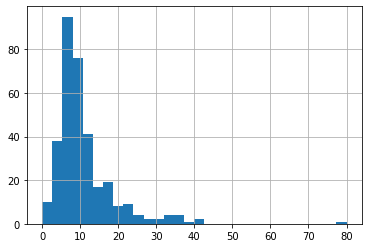

In [80]:
log_metadata_df.chunk_duration_sec.hist(bins=30)

In [74]:
log_metadata_df.chunk_duration_sec.describe()

count    333.000000
mean      10.729730
std        7.970895
min        0.000000
25%        6.000000
50%        8.000000
75%       13.000000
max       80.000000
Name: chunk_duration_sec, dtype: float64

In [81]:
np.median(log_metadata_df.chunk_duration_sec)

8.0

Note: So I just did 3 5-minutes segments and got about 60 segments.
That is about 20 segments per clip, which is great!

In [76]:
log_metadata_df.to_csv(os.path.join(OUTFILE, 'log_metadata.csv'))